In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats

In [123]:
stats.t.ppf(0.95, len(df)-2)

1.7709333959867988

# Подготовка данных

In [106]:
df = pd.read_csv(r'toyota.csv').head(15)

In [107]:
df

model  year  price transmission  mileage fuelType  tax   mpg  engineSize
0    GT86  2016  16000       Manual    24089   Petrol  265  36.2         2.0
1    GT86  2017  15995       Manual    18615   Petrol  145  36.2         2.0
2    GT86  2015  13998       Manual    27469   Petrol  265  36.2         2.0
3    GT86  2017  18998       Manual    14736   Petrol  150  36.2         2.0
4    GT86  2017  17498       Manual    36284   Petrol  145  36.2         2.0
5    GT86  2017  15998       Manual    26919   Petrol  260  36.2         2.0
6    GT86  2017  18522       Manual    10456   Petrol  145  36.2         2.0
7    GT86  2017  18995       Manual    12340   Petrol  145  36.2         2.0
8    GT86  2020  27998       Manual      516   Petrol  150  33.2         2.0
9    GT86  2016  13990       Manual    37999   Petrol  265  36.2         2.0
10   GT86  2013  10495       Manual    72000   Petrol  265  36.2         2.0
11   GT86  2017  17990       Manual    12597   Petrol  145  36.2         2.0
12   GT86  2017  16995       Manual    36100   Petrol  145  36.2         2.0
13   GT86  2019  23995       Manual      995   Petrol  145  33.2         2.0
14   GT86  2018  18498       Manual    35228   Petrol  145  36.2         2.0

In [108]:
df = df.sort_values(by='mileage')

In [109]:
df = df[['mileage', 'price']]

In [110]:
df

mileage  price
8       516  27998
13      995  23995
6     10456  18522
7     12340  18995
11    12597  17990
3     14736  18998
1     18615  15995
0     24089  16000
5     26919  15998
2     27469  13998
14    35228  18498
12    36100  16995
4     36284  17498
9     37999  13990
10    72000  10495

# Поиск a и b

In [111]:
xm = df['mileage'].mean()
ym = df['price'].mean()
um = np.log10(df['mileage']).mean()
u2m = np.square(np.log10(df['mileage'])).mean()
uym = np.multiply(np.log10(df['mileage']), df['price']).mean()

sum = {'x': xm, 'y': ym, 'u': um, 'u^2': u2m, 'uy': uym}
df1 = pd.DataFrame(sum, index =['1'])
df1

x        y         u        u^2            uy
1  24422.866667  17731.0  4.180773  17.799468  72053.851985

In [112]:
def inv_matrix(a, b):
    ylist = []
    a_matrix = np.matrix(a)
    b_matrix = np.matrix(b).transpose()
    inv_a = a_matrix.getI()
    total = inv_a.dot(b_matrix)
    total = list(np.squeeze(np.asarray(total)))
    for elem in total:
        ylist.append(elem)
    return ylist

a = [[u2m, um], [um, 1]]
b = [uym, ym]

aAndB = inv_matrix(a, b)
print('a =', aAndB[0], 'b =',  aAndB[1])

a = -6473.546563322481 b = 44795.43034979934


# Получение регрессионного уравнения

In [113]:
k = inv_matrix(a, b)
def f(x): 
    return k[0]*math.log10(x)+k[1]

# Поиск коэффициента детерминации

In [114]:
suma = 0
sumb = 0
for i in range(len(df)):
    suma += (f(df['mileage'][i]) - ym)**2
    sumb += (df['price'][i] - ym)**2

R2 = suma/sumb
print('R^2 =',R2)

R^2 = 0.843114633957418


# Проверка адекватности уравнения

In [115]:
F = R2*(len(df)-2)/(1-R2)

In [116]:
if F > stats.f.ppf(0.95, 1, len(df)-2):
    print(F, '>', stats.f.ppf(0.95, 1, len(df)-2), 'значит признается статистическая значимость и надежность уравнения')
else:
    print(F, '<', stats.f.ppf(0.95, 1, len(df)-2), 'значит не признается статистическая значимость и надежность уравнения')

69.8630504420121 > 4.667192731826848 значит признается статистическая значимость и надежность уравнения


# Выборочная остаточная дисперсия

In [117]:
sumc = 0
for i in range(len(df)):
    sumc = sumc + (f(df['mileage'][i]) - df['price'][i])**2

s2 = sumc / (len(df)-2)
s2

2884668.337997864

# Прогноз и доверительный интервал

In [118]:
sumd = 0
for i in range(len(df)):
    sumd += (df['mileage'][i] - xm)**2

In [119]:
def s2y(x):
    return s2 * (1 + 1/len(df)+((x - xm)**2)/sumd)

In [124]:
def inter(x):
    sy = math.sqrt(s2y(x))
    begin = f(x) - stats.t.ppf(0.95, len(df)-2)*sy
    end = f(x) + stats.t.ppf(0.95, len(df)-2)*sy
    return f(x), begin, end, sy

In [125]:
ans = inter(40000)
print('sy^2 =', ans[3],'y*p =', ans[0], ans[1],'< y*p <', ans[2])

sy^2 = 1797.1093140362786 y*p = 15003.78070873432 11821.219808268546 < y*p < 18186.341609200095


# Доверительный интервал для линии регрессии

# Попытка в показательную функцию (по идее не нужно оставил, на всякий случай)

In [60]:
sumx1 = 0
sumy1 = 0
sumz = 0
sumx2 = 0
sumzx = 0
for i in range(len(df)):
    sumx1 += df['mileage'][i]
    sumy1 += df['price'][i]
    z = math.log10(df['price'][i])
    sumz += z
    sumx2 += df['mileage'][i] * df['mileage'][i]
    sumzx += z * df['mileage'][i]
    
xm1 = sumx1/len(df)
ym1 = sumy1/len(df)
zm = sumz/len(df)
x2m = sumx2/len(df)
zxm = sumzx/len(df)

sum = {'x': xm1, 'y': ym1, 'z': zm, 'x^2': x2m, 'uy': zxm}
df1 = pd.DataFrame(sum, index =['1'])
df1

x        y         z          x^2             uy
1  24422.866667  17731.0  4.238186  902223015.4  102090.054839

In [61]:
a1 = [[x2m, xm], [xm, 1]]
b1 = [zxm, zm]

print(inv_matrix(a1, b1))

[-4.639749552489108e-06, 4.351501612037065]


In [62]:
def f1(x):
    k1 = inv_matrix(a1, b1)
    return 10**(k1[0]*x+k1[1])

# Отрисовка выборки и регрессионного уравнения

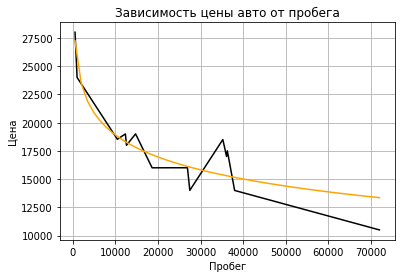

In [100]:
xnew = np.linspace(min(df['mileage']),max(df['mileage']))
ynew = [f(x) for x in xnew]
y1new = [f1(x) for x in xnew]
plt.title("Зависимость цены авто от пробега") # заголовок
plt.xlabel("Пробег") # ось абсцисс
plt.ylabel("Цена") # ось ординат
plt.plot(df['mileage'], df['price'], 'black')
plt.plot(xnew, ynew, 'orange')
plt.grid(True)
plt.show()

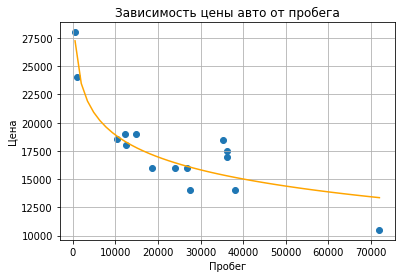

In [104]:
xnew = np.linspace(min(df['mileage']),max(df['mileage']))
ynew = [f(x) for x in xnew]
y1new = [f1(x) for x in xnew]
plt.title("Зависимость цены авто от пробега") # заголовок
plt.xlabel("Пробег") # ось абсцисс
plt.ylabel("Цена") # ось ординат
plt.scatter(df['mileage'], df['price'])
plt.plot(xnew, ynew, 'orange')
plt.grid(True)
plt.show()